## The Challenge
The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we are going to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

In [1]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
# ---

%matplotlib inline
import pandas as pd
pd.options.display.max_columns = 100
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np

import os
from sklearn import metrics, preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
pd.options.display.max_rows = 100

### Load the data and understand data


In [2]:
train_data = pd.read_csv("C:/Users/ersar/OneDrive/Desktop/Kaggle/Titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test_data = pd.read_csv("C:/Users/ersar/OneDrive/Desktop/Kaggle/Titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [6]:
survived_sex = train_data[train_data['Survived']==1]['Sex'].value_counts()
dead_sex = train_data[train_data['Survived']==0]['Sex'].value_counts()
df = pd.DataFrame([survived_sex,dead_sex])
df

,female,male
Sex,233,109
Sex,81,468


In [7]:
df.index = ['Survived','Dead']

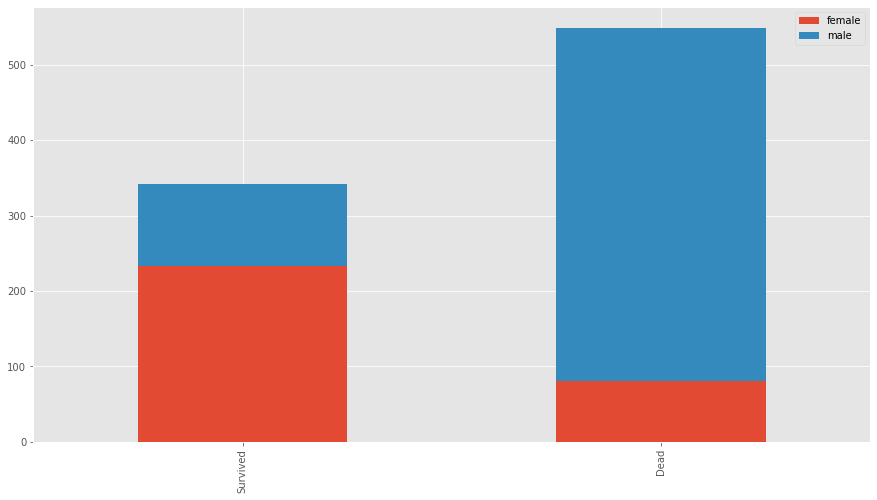

In [8]:
df.plot(kind='bar', stacked=True, figsize=(15,8))

#### Let's examine Categorical variable

In [9]:
missing =round(100*train_data.select_dtypes(include='object').isnull().sum()[train_data.select_dtypes(include='object').isnull().sum()>0]/len(train_data.PassengerId),2)
missing.loc[missing > 0]

Cabin       77.10
Embarked     0.22
dtype: float64

In [10]:
missing =round(100*test_data.select_dtypes(include='object').isnull().sum()[test_data.select_dtypes(include='object').isnull().sum()>0]/len(test_data.PassengerId),2)
missing.loc[missing > 0]


Cabin    78.23
dtype: float64

we assume NaN data as None,so impute Nan as None

In [11]:
test_data['Cabin']=test_data['Cabin'].fillna('U') #unknown
train_data['Cabin']=train_data['Cabin'].fillna('U')


Impute Embarked as mode which is 'S'

In [12]:
train_data['Embarked']=train_data['Embarked'].fillna('S')

In [13]:
missing =train_data.select_dtypes(include='object').isnull().sum()[train_data.select_dtypes(include='object').isnull().sum()>0]
missing.loc[missing > 0]

Series([], dtype: int64)

Now look into numerical missing value

In [14]:
# check the null values in the numerical data
missing =round(100*(train_data.select_dtypes(include=['int64','float']).isnull().sum()/len(train_data.PassengerId)),2)
missing.loc[missing > 0]

Age    19.87
dtype: float64

In [15]:
# check the null values in the numerical data
missing =round(100*(test_data.select_dtypes(include=['int64','float']).isnull().sum()/len(test_data.PassengerId)),2)
missing.loc[missing > 0]

Age     20.57
Fare     0.24
dtype: float64

In test data we have some missing value in Fare and we beleave that there is some fare, so i am going to impute missing value with median of fare

In [16]:
test_data['Fare'] = test_data['Fare'].replace(np.nan, test_data['Fare'].median())

In [17]:
   data = [train_data, test_data]

for dataset in data:
    # we extract the title from each name
    dataset['Title'] = dataset['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    
    # a map of more aggregated titles
    Title_Dictionary = {
                        "Capt":       "Officer",
                        "Col":        "Officer",
                        "Major":      "Officer",
                        "Jonkheer":   "Royalty",
                        "Don":        "Royalty",
                        "Sir" :       "Royalty",
                        "Dr":         "Officer",
                        "Rev":        "Officer",
                        "the Countess":"Royalty",
                        "Dona":       "Royalty",
                        "Mme":        "Mrs",
                        "Mlle":       "Miss",
                        "Ms":         "Mrs",
                        "Mr" :        "Mr",
                        "Mrs" :       "Mrs",
                        "Miss" :      "Miss",
                        "Master" :    "Master",
                        "Lady" :      "Royalty"

                        }
    
    # we map each title
    dataset['Title'] = dataset.Title.map(Title_Dictionary)

In [18]:
# now let's drop Name column because it won't help more in analysis
train_data = train_data.drop(['Name'], axis=1)
test_data = test_data.drop(['Name'], axis=1)

In [19]:
train_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,U,S,Mr
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,U,S,Miss
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,male,35.0,0,0,373450,8.0500,U,S,Mr


let's impute age with there median of sex and class according to title

In [20]:
grouped_train = train_data.groupby(['Sex','Pclass','Title'])
grouped_median_train = grouped_train.median()

grouped_test = test_data.groupby(['Sex','Pclass','Title'])
grouped_median_test = grouped_test.median()

In [21]:
def fillAges(row, grouped_median):
    if row['Sex']=='female' and row['Pclass'] == 1:
        if row['Title'] == 'Miss':
            return grouped_median.loc['female', 1, 'Miss']['Age']
        elif row['Title'] == 'Mrs':
            return grouped_median.loc['female', 1, 'Mrs']['Age']
        elif row['Title'] == 'Officer':
            return grouped_median.loc['female', 1, 'Officer']['Age']
        elif row['Title'] == 'Royalty':
            return grouped_median.loc['female', 1, 'Royalty']['Age']

    elif row['Sex']=='female' and row['Pclass'] == 2:
        if row['Title'] == 'Miss':
            return grouped_median.loc['female', 2, 'Miss']['Age']
        elif row['Title'] == 'Mrs':
            return grouped_median.loc['female', 2, 'Mrs']['Age']

    elif row['Sex']=='female' and row['Pclass'] == 3:
        if row['Title'] == 'Miss':
            return grouped_median.loc['female', 3, 'Miss']['Age']
        elif row['Title'] == 'Mrs':
            return grouped_median.loc['female', 3, 'Mrs']['Age']

    elif row['Sex']=='male' and row['Pclass'] == 1:
        if row['Title'] == 'Master':
            return grouped_median.loc['male', 1, 'Master']['Age']
        elif row['Title'] == 'Mr':
            return grouped_median.loc['male', 1, 'Mr']['Age']
        elif row['Title'] == 'Officer':
            return grouped_median.loc['male', 1, 'Officer']['Age']
        elif row['Title'] == 'Royalty':
            return grouped_median.loc['male', 1, 'Royalty']['Age']

    elif row['Sex']=='male' and row['Pclass'] == 2:
        if row['Title'] == 'Master':
            return grouped_median.loc['male', 2, 'Master']['Age']
        elif row['Title'] == 'Mr':
            return grouped_median.loc['male', 2, 'Mr']['Age']
        elif row['Title'] == 'Officer':
            return grouped_median.loc['male', 2, 'Officer']['Age']

    elif row['Sex']=='male' and row['Pclass'] == 3:
        if row['Title'] == 'Master':
            return grouped_median.loc['male', 3, 'Master']['Age']
        elif row['Title'] == 'Mr':
            return grouped_median.loc['male', 3, 'Mr']['Age']
    
    

In [22]:
train_data['Age'] = train_data.apply(lambda r : fillAges(r, grouped_median_train) if np.isnan(r['Age']) else r['Age'], axis=1)
    

In [23]:
test_data['Age'] = test_data.apply(lambda r : fillAges(r, grouped_median_test) if np.isnan(r['Age']) else r['Age'], axis=1)


In [24]:
grp=train_data.groupby("Sex")["Age"]
grp.describe()

,count,mean,std,min,25%,50%,75%,max
Sex,,,,,,,,
female,314.0,27.251592,13.394959,0.75,18.0,25.5,36.0,63.0
male,577.0,30.164939,13.450056,0.42,23.0,27.0,37.0,80.0


In [25]:
missing =round(100*(test_data.select_dtypes(include=['int64','float']).isnull().sum()/len(test_data.PassengerId)),2)
missing.loc[missing > 0]

Series([], dtype: float64)

In [26]:
missing =round(100*(train_data.select_dtypes(include=['int64','float']).isnull().sum()/len(train_data.PassengerId)),2)
missing.loc[missing > 0]

Series([], dtype: float64)

So now both dataset have no missing value, now we can move further for analysis

### Data Preparation

##### let's convert Categorical column 


In [27]:
# mapping each Cabin value with the cabin letter
train_data['Cabin'] = train_data['Cabin'].map(lambda c : c[0])
    
# dummy encoding ...
cabin_dummies = pd.get_dummies(train_data['Cabin'], prefix='Cabin')
    
train_data = pd.concat([train_data,cabin_dummies], axis=1)
    
train_data.drop('Cabin', axis=1, inplace=True)
    
# on Test
test_data['Cabin'] = test_data['Cabin'].map(lambda c : c[0])
    
# dummy encoding ...
cabin_dummies = pd.get_dummies(test_data['Cabin'], prefix='Cabin')
    
test_data = pd.concat([test_data,cabin_dummies], axis=1)
    
test_data.drop('Cabin', axis=1, inplace=True)
    

In [28]:
genders = {"male": 0, "female": 1}
data = [train_data, test_data]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

train_data['Ticket'].describe()

count          891
unique         681
top       CA. 2343
freq             7
Name: Ticket, dtype: object

In [29]:
train_data = train_data.drop(['Ticket'], axis=1)
test_data = test_data.drop(['Ticket'], axis=1)

In [30]:
ports = {"S": 0, "C": 1, "Q": 2}
data = [train_data, test_data]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

In [31]:
data = [train_data, test_data]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6


In [32]:
train_data.head(10)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,1,0,3,0,2,1,0,7.2500,0,Mr,0,0,0,0,0,0,0,0,1
1,2,1,1,1,5,1,0,71.2833,1,Mrs,0,0,1,0,0,0,0,0,0
2,3,1,3,1,3,0,0,7.9250,0,Miss,0,0,0,0,0,0,0,0,1
3,4,1,1,1,5,1,0,53.1000,0,Mrs,0,0,1,0,0,0,0,0,0
4,5,0,3,0,5,0,0,8.0500,0,Mr,0,0,0,0,0,0,0,0,1
5,6,0,3,0,3,0,0,8.4583,2,Mr,0,0,0,0,0,0,0,0,1
6,7,0,1,0,6,0,0,51.8625,0,Mr,0,0,0,0,1,0,0,0,0
7,8,0,3,0,0,3,1,21.0750,0,Master,0,0,0,0,0,0,0,0,1
8,9,1,3,1,3,0,2,11.1333,0,Mrs,0,0,0,0,0,0,0,0,1
9,10,1,2,1,1,1,0,30.0708,1,Mrs,0,0,0,0,0,0,0,0,1


In [33]:
data = [train_data, test_data]

for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

In [34]:
data = [train_data, test_data]
for dataset in data:
    dataset['Age_Class']= dataset['Age']* dataset['Pclass']

In [35]:
data = [train_data, test_data]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)
train_data['not_alone'].value_counts()

1    537
0    354
Name: not_alone, dtype: int64

In [36]:
train_data = train_data.drop(['Title'], axis=1)
test_data = test_data.drop(['Title'], axis=1)

In [37]:
data = [train_data, test_data]
for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['relatives']+1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)
# Let's take a last look at the training set, before we start training the models.
train_data.head(20)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Age_Class,relatives,not_alone,Fare_Per_Person
0,1,0,3,0,2,1,0,0,0,0,0,0,0,0,0,0,0,1,6,1,0,0
1,2,1,1,1,5,1,0,3,1,0,0,1,0,0,0,0,0,0,5,1,0,1
2,3,1,3,1,3,0,0,1,0,0,0,0,0,0,0,0,0,1,9,0,1,1
3,4,1,1,1,5,1,0,3,0,0,0,1,0,0,0,0,0,0,5,1,0,1
4,5,0,3,0,5,0,0,1,0,0,0,0,0,0,0,0,0,1,15,0,1,1
5,6,0,3,0,3,0,0,1,2,0,0,0,0,0,0,0,0,1,9,0,1,1
6,7,0,1,0,6,0,0,3,0,0,0,0,0,1,0,0,0,0,6,0,1,3
7,8,0,3,0,0,3,1,2,0,0,0,0,0,0,0,0,0,1,0,4,0,0
8,9,1,3,1,3,0,2,1,0,0,0,0,0,0,0,0,0,1,9,2,0,0
9,10,1,2,1,1,1,0,2,1,0,0,0,0,0,0,0,0,1,2,1,0,1


In [38]:
train_data=train_data.drop(['Cabin_T'], axis=1)
X_train = train_data.drop(['PassengerId' ,'Survived'], axis=1)
y_train = train_data["Survived"]
X_test  = test_data.drop("PassengerId", axis=1).copy()

In [39]:
X_train.head(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_U,Age_Class,relatives,not_alone,Fare_Per_Person
0,3,0,2,1,0,0,0,0,0,0,0,0,0,0,1,6,1,0,0
1,1,1,5,1,0,3,1,0,0,1,0,0,0,0,0,5,1,0,1
2,3,1,3,0,0,1,0,0,0,0,0,0,0,0,1,9,0,1,1
3,1,1,5,1,0,3,0,0,0,1,0,0,0,0,0,5,1,0,1
4,3,0,5,0,0,1,0,0,0,0,0,0,0,0,1,15,0,1,1


In [40]:
X_test.head(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_U,Age_Class,relatives,not_alone,Fare_Per_Person
0,3,0,5,0,0,0,2,0,0,0,0,0,0,0,1,15,0,1,0
1,3,1,6,1,0,0,0,0,0,0,0,0,0,0,1,18,1,0,0
2,2,0,6,0,0,1,2,0,0,0,0,0,0,0,1,12,0,1,1
3,3,0,3,0,0,1,0,0,0,0,0,0,0,0,1,9,0,1,1
4,3,1,2,1,1,1,0,0,0,0,0,0,0,0,1,6,2,0,0


In [41]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [42]:
# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 100)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

classifier.score(X_train, y_train)
acc_random_forest = round(classifier.score(X_train, y_train) * 100, 2)

In [43]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [44]:
acc_random_forest

91.69

In [45]:
decision_tree = DecisionTreeClassifier() 
decision_tree.fit(X_train, y_train) 
Y_pred = decision_tree.predict(X_test) 
acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)

In [46]:
Y_pred

array([0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [47]:
acc_decision_tree

91.69

In [48]:
from sklearn.svm import SVC, LinearSVC
linear_svc = LinearSVC(max_iter= 100, dual=False)
linear_svc.fit(X_train, y_train)

Y_pred = linear_svc.predict(X_test)

acc_linear_svc = round(linear_svc.score(X_train, y_train) * 100, 2)

In [49]:
Y_pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [50]:
acc_linear_svc

80.81

In [51]:
results = pd.DataFrame({
    'Model': ['Random Forest','Decision Tree','Support Vector Machines'],
    'Score': [acc_random_forest, acc_decision_tree, acc_linear_svc]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head(9)

,Model
Score,
91.69,Random Forest
91.69,Decision Tree
80.81,Support Vector Machines


In [52]:
#K-Fold Cross Validation
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.78888889 0.80898876 0.71910112 0.79775281 0.87640449 0.82022472
 0.79775281 0.79775281 0.85393258 0.84269663]
Mean: 0.8103495630461921
Standard Deviation: 0.04083051522970346


In [53]:
# Feature Importance
importances = pd.DataFrame({'feature':train_data.drop(['PassengerId' , 'Survived'], axis=1).columns.values,'importance':np.round(classifier.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

,importance
feature,
Sex,0.296
Age_Class,0.119
Age,0.082
Pclass,0.073
Fare,0.071
Embarked,0.068
relatives,0.063
Cabin_U,0.050
Fare_Per_Person,0.046


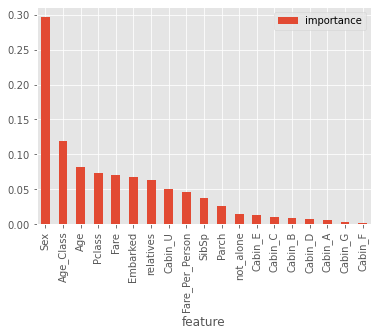

In [54]:
importances.plot.bar()

In [55]:
train_data = train_data.drop("not_alone", axis=1)
test_data = test_data.drop("not_alone", axis=1)

train_data  = train_data.drop("Parch", axis=1)
test_data  = test_data.drop("Parch", axis=1)

train_data = train_data.drop("Fare", axis=1)
test_data = test_data.drop("Fare", axis=1)

train_data  = train_data.drop("Fare_Per_Person", axis=1)
test_data  = test_data.drop("Fare_Per_Person", axis=1)

In [56]:
#Retranning the model

classifier = RandomForestClassifier(n_estimators=100, oob_score = True)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

classifier.score(X_train, y_train)
acc_random_forest = round(classifier.score(X_train, y_train) * 100, 2)
print(round(acc_random_forest,2,), "%")

91.69 %


In [57]:
print("oob score:", round(classifier.oob_score_, 4)*100, "%")

oob score: 80.47 %


In [60]:
param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10], "min_samples_split" : [2,10,30,35,40], "n_estimators": [100, 300, 500]}


In [61]:

from sklearn.model_selection import GridSearchCV, cross_val_score
rf = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
clf = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1)
clf.fit(X_train, y_train)
clf.best_params_

{'criterion': 'entropy',
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 100}

In [63]:
classifier = RandomForestClassifier(criterion = "gini", min_samples_leaf = 5, min_samples_split = 2, n_estimators=100, 
                                       max_features='auto', oob_score=True, random_state=1, n_jobs=-1)

classifier.fit(X_train, y_train)
y_prediction = classifier.predict(X_test)

classifier.score(X_train, y_train)

print("oob score:", round(classifier.oob_score_, 4)*100, "%")

oob score: 82.49 %


In [64]:
#Confussion Matrics
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
predictions = cross_val_predict(classifier, X_train, y_train, cv=3)
confusion_matrix(y_train, predictions)

array([[489,  60],
       [101, 241]], dtype=int64)

In [65]:
from sklearn.metrics import precision_score, recall_score

print("Precision:", precision_score(y_train, predictions))
print("Recall:",recall_score(y_train, predictions))

Precision: 0.8006644518272426
Recall: 0.7046783625730995


In [66]:
from sklearn.metrics import f1_score
f1_score(y_train, predictions)

0.7496111975116642

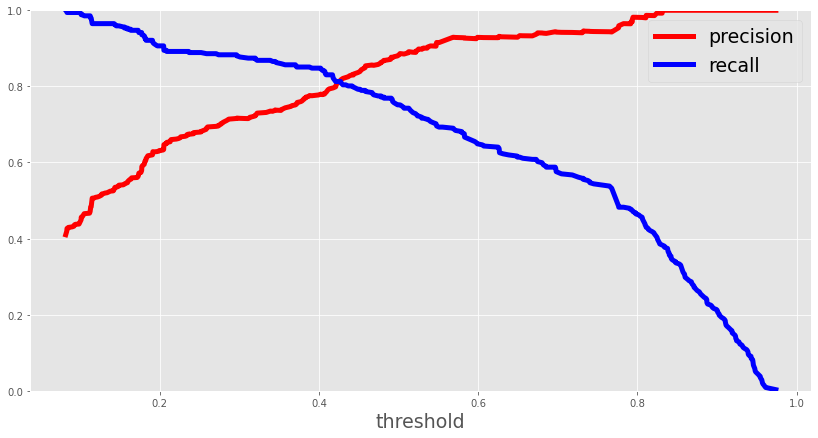

In [67]:
from sklearn.metrics import precision_recall_curve

# getting the probabilities of our predictions
y_scores =classifier.predict_proba(X_train)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(y_train, y_scores)
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

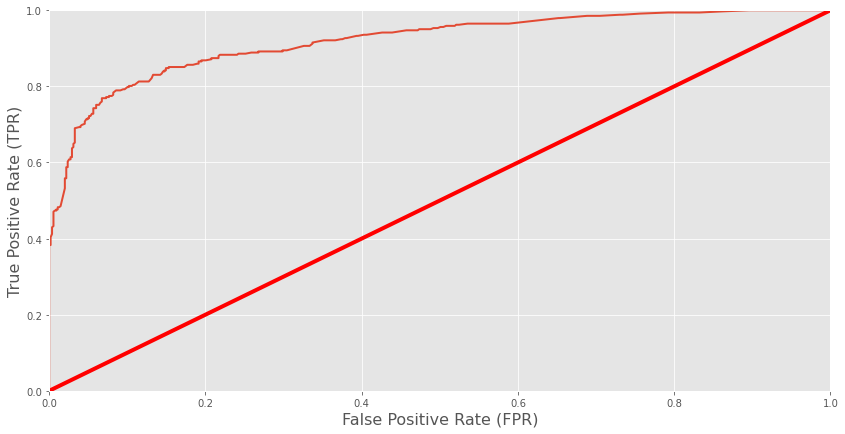

In [68]:
from sklearn.metrics import roc_curve
# compute true positive rate and false positive rate
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_scores)
# plotting them against each other
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

In [69]:
from sklearn.metrics import roc_auc_score
r_a_score = roc_auc_score(y_train, y_scores)
print("ROC-AUC-Score:", r_a_score)

ROC-AUC-Score: 0.9186372884244614


In [70]:
prediction_submission = pd.DataFrame({'PassengerId':test_data['PassengerId'],'Survived':y_pred})

In [71]:
prediction_submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [72]:
prediction_submission.to_csv('prediction_submission.csv', sep=",")